<a href="https://colab.research.google.com/github/sayem-eee-kuet/pinn-research/blob/master/Burgers_matlab_new_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install --upgrade pyDOE
# !sudo apt-get install texlive-latex-recommended 
# !sudo apt install texlive-latex-extra
# !sudo apt install dvipng
# !sudo apt-get install texlive-latex-base
# !sudo apt-get install texlive-fonts-recommended
# !sudo apt-get install texlive-fonts-extra
# !sudo apt-get install texlive-latex-extra

Requirement already up-to-date: pyDOE in /usr/local/lib/python3.6/dist-packages (0.3.8)


# New Section

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import sys
# sys.path.insert(0, './Utilities/')
sys.path.insert(0, '/content/drive/My Drive/ColabNotebooks/PINN/Utilities/')
# from SmoothSolutionBurgers import data_gen
import matplotlib
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=False
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from plotting import newfig, savefig
from pyDOE import lhs
from scipy.interpolate import griddata
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf  # tf v1.x
import time
import pandas as pd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import sys


In [4]:
np.random.seed(1234)
tf.set_random_seed(1234)
np.set_printoptions(threshold=sys.maxsize)

In [8]:
class PhysicsInformedNN:
    # Initialize the class
    # def __init__(self, XX_energy, X_u, u, X_f, layers, lb, ub, nu):
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):

        self.lb = lb
        self.ub = ub

        # self.x_energy = XX_energy[:, 0:1] # energy x
        # # print(self.x_energy.shape)
        # self.t_energy = XX_energy[:, 1:2] # energy t

        self.x_u = X_u[:, 0:1]  # training x
        self.t_u = X_u[:, 1:2]  # training t

        self.x_f = X_f[:, 0:1]  # collocation point x
        # print(self.x_f.shape)
        self.t_f = X_f[:, 1:2]  # collocation point t

        self.u = u  # u(t,x) in BC and IC

        self.layers = layers
        self.nu = nu

        # Initialize NNs
        # self.weights, self.biases = self.initialize_NN(layers)
        self.weights, self.biases, self.acti_param = self.initialize_NN(layers)

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_u_tf = tf.placeholder(
            tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(
            tf.float32, shape=[None, self.t_u.shape[1]])
        self.u_tf = tf.placeholder(
            tf.float32, shape=[None, self.u.shape[1]])

        self.x_f_tf = tf.placeholder(
            tf.float32, shape=[None, self.x_f.shape[1]])
        # matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['text.latex.unicode']=Trueprint(x_f_tf.shape)
        self.t_f_tf = tf.placeholder(
            tf.float32, shape=[None, self.t_f.shape[1]])

        # self.x_energy_tf = tf.placeholder(
        #     tf.float32, shape=[None, self.x_energy.shape[1]])
        # # print(XX_energy_tf.shape)
        # self.t_energy_tf = tf.placeholder(
        #     tf.float32, shape=[None, self.t_energy.shape[1]])

        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) # t is not const here
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        # self.u_conv = self.net_u(self.x_energy_tf, self.t_energy_tf) 

        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred)) + self.S(self.acti_param)
                    
                    # + tf.square(np.pi - 2*np.pi*tf.reduce_mean(self.u_conv)) 
        # self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
        #             tf.square(0 - 2*tf.reduce_mean(self.u_conv))
            # New loss function
            # tf.reduce_mean(tf.square(self.u_conv))

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 5*10**4,
                                                                         'maxfun': 5*10**4,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1.0 * np.finfo(float).eps})

        init = tf.global_variables_initializer()
        self.sess.run(init)

    def S(self, a):  # Slope recovery term
        y = 0
        for i in range(0, len(a)):
            y += tf.exp(tf.reduce_mean(a[i]))
        slope_term = 1 / (tf.reduce_mean(y))
        return slope_term

    # def initialize_NN(self, layers):
    #     weights = []
    #     biases = []
    #     num_layers = len(layers)
    #     for l in range(0, num_layers - 1):
    #         print("l = ", l)
    #         W = self.xavier_init(size=[layers[l], layers[l + 1]])
    #         print(W.shape)
    #         b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
    #         print(b.shape)
    #         weights.append(W)
    #         biases.append(b)
    #     return weights, biases

    def initialize_NN(self, layers):
        weights = []
        biases = []
        acti_param = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(
                tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)

            # Neuron wise activation slope
            a = tf.Variable(tf.constant(0.1, shape=[1, layers[1 + l]]))
            weights.append(W)
            biases.append(b)
            acti_param.append(a)
        return weights, biases, acti_param

    def xavier_init(self, size):
        in_dim = size[0] # H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)


## Modified architecture
    def neural_net(self, X, weights, biases, acti_param):
        num_layers = len(weights) + 1
        H = X #2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = acti_param[l]
            if l % 2 == 0:
                H = tf.tanh(tf.multiply(tf.multiply(10.0, a),tf.add(tf.matmul(H, W), b)))
            else:
                H = tf.tanh(tf.multiply(tf.multiply(10.0, a),tf.add(tf.matmul(H, W), b)))
        W = weights[-1]
        b = biases[-1]
        # a = acti_param[]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, t):
        # u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases)
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases, self.acti_param)
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + u * u_x - self.nu * u_xx
        return f

    def callback(self, loss): #, x_energy_tf, t_energy_tf):
        # U_energy = tf.reduce_mean(2*np.pi*self.u_conv)
        print('Loss:', loss)

    def train(self):

        tf_dict = {self.x_u_tf: self.x_u,  self.t_u_tf: self.t_u, self.u_tf: self.u, self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

    def predict(self, X_star):
        u_star = self.sess.run(
            self.u_pred, {self.x_u_tf: X_star[:, 0:1], self.t_u_tf: X_star[:, 1:2]})
        f_star = self.sess.run(
            self.f_pred, {self.x_f_tf: X_star[:, 0:1], self.t_f_tf: X_star[:, 1:2]})

        return u_star, f_star


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


(100, 256)
(100, 256)


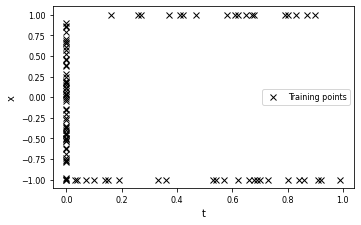

In [26]:
### Data loading and processing 
nu = 0.01 / np.pi
noise = 0.0

N_u = 100
# N_u = int(sys.argv[1])
# print(N_u)
N_f = 10**4
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# layers = [2, 20, 20, 1]
# layers = [2, 3, 1]

# data = scipy.io.loadmat('./Data/burgers_shock.mat')
data = scipy.io.loadmat('/content/drive/My Drive/ColabNotebooks/PINN/Data/burgers_shock.mat')

t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
# # print(t)
# # print("Okay here")
# # print(Exact.flatten()[:, None])
# print(Exact.shape)
# # print(t[25])

# # print(t)
# # print(x)

X, T = np.meshgrid(x, t)

# print(T.shape)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

u_star = Exact.flatten()[:, None]

# # # Doman bounds
lb = X_star.min(0)
# print(lb)
ub = X_star.max(0)
# print(ub)
# print(X[0:1, :].T)
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))  # initial condition
# print(xx1)
# u_ic  # Exact[0:1, :].T  # u_ic # training data on IC
uu1 = Exact[0:1, :].T
# plt.plot(X[0:1, :].T, uu1)
# plt.show()
# # print(U_int.shape)
# Pi_expect = 2*np.pi*np.mean(uu1)
# print(Pi_expect)
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))  # x = -1 boundary condition
# print(xx2)
uu2 = Exact[:, 0:1]  # u_lbc  #   # traning data on x = -1. Close to 0
# uu2 = u_lbc
# print(uu2)
# # # # plt.plot()
xx3 = np.hstack((X[:, -1:], T[:, -1:]))
# # # print(xx3.shape)  # x = 1 boundary condition
uu3 = Exact[:, -1:]  # traning data on x = 1. Close to 0
# print(uu3)
# uu3 = u_rbc  # Exact[:, -1:]
# print(list(zip(uu2, uu3)))

# # # training data: IC + BC points => (t,x)
X_u_train = np.vstack([xx1, xx2, xx3])
# print(X_u_train)
# # # print("The shape of X_u_train", X_u_train.shape)
# plt.scatter(X_u_train[:, 1], X_u_train[:, 0], label="IC/BC points")
# plt.xlabel("t")
# plt.ylabel("x")
# # plt.show()
# plt.savefig('figures/training_t_x_plane.png')

# print(ub - lb)
X_f_train = lb + (ub - lb) * lhs(2, N_f)  # collocation point
# print(X_f_train[:, 0:1])
# plt.scatter(X_f_train[:,1:2], X_f_train[:, 0:1], label="Collocation point")
# plt.show()
# print(X_f_train)
# # print(X_f_train)
# ## print("The shape of collocation points", X_f_train.shape)
# # print(X_f_train)
X_f_train = np.vstack((X_f_train, X_u_train))
# plt.scatter(X_f_train[:, 1:2], X_f_train[:, 0:1])
# # plt.show()
# # print(X_f_train)
# # combination of the values at BC and IC = u_train
u_train = np.vstack([uu1, uu2, uu3])
# # print("The shape of u_train", u_train.shape)
# print(u_train)

# # Randomly pick the 100 points form X_u_train
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
# print(idx.shape)
X_u_train = X_u_train[idx, :]  # Final training data
# print(X_u_train)
plt.plot(X_u_train[:, 1:2], X_u_train[:, 0:1], 'kx', label="Training points")
plt.xlabel("t")
plt.ylabel("x")
plt.legend(frameon=True, loc='best')

# plt.legend(loc='best', bbox_to_anchor=(0.5, -0.05)) #, shadow=True, ncol=2)
u_train = u_train[idx, :]  # Final training data

print(X.shape)
print(T.shape)
# ############ Data point for Energy #################
# ## Goal: take all data point at snapshot t = t    #
#                 ###############                   #
# idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
# XX_energy = np.hstack([X[10:11, :].T, T[10:11, :].T])
# index = np.random.choice(XX_energy.shape[0], 10, replace=False)
# # # print(idx)
# XX_energy = XX_energy[index, :]
# # plt.savefig('figures/training_t_x_plane.png')
# savefig('figures/total_training_dataset')
# plt.scatter(XX_energy[:, 1:2], XX_energy[:, 0:1])
# plt.show()
# ###################################################

In [ ]:
# data = scipy.io.loadmat('./Data/data_testing_150s.mat')
# # data = scipy.io.loadmat('Data/data_testing.mat')

# t = data['t'].flatten()[:, None]
# x = data['x'].flatten()[:, None]
# usol = np.real(data['usol']).T
# print(type(t[-2]))
# FinalTime = float(t[-2])
# FinalTime = round(FinalTime,3)
# fig, axes = plt.subplots(nrows=2, ncols=1)  # , figsize=(6, 4))
#     # fig.tight_layout()
#     # ax = plt.subplot(211)
#     # plt.plot(x, u_IC, 'r', label="initial condition")
# axes[0].plot(x, usol[0, :], 'r', label="initial condition")
# axes[0].plot(x, usol[-1, :], 'g--', label="final")
# axes[0].legend()
# axes[0].set_xlabel('$x$')
# axes[0].set_ylabel('$u(t,x)$')
# axes[0].set_title('Numerical Solution at final time = ' + str(FinalTime) + 's')

# h = axes[1].imshow(np.real(usol.T), interpolation='nearest', cmap='jet',
#           extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')

# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(h, cax=cax)
# axes[1].set_xlabel('$t$')
# axes[1].set_ylabel('$x$')
# axes[1].set_title('Solution on t-x plane')

# # fig.suptitle('Numerical Solver', fontsize=12)
# fig.tight_layout()
# savefig('figures/numerical_exact_solution_150')
# # fig.savefig('./figures/numerical_exact_solution.png')

In [16]:
############## model ##################
# model = PhysicsInformedNN(XX_energy, X_u_train, u_train, X_f_train, layers, lb, ub, nu)
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [17]:
############## Training ############
start_time = time.time()
model.train()  # training
elapsed = time.time() - start_time
hours, rem = divmod(elapsed, 3600)
minutes, seconds = divmod(rem, 60)
print('Training time: {:0>2}:{:0>2}:{:05.2f}'.format(
    int(hours), int(minutes), seconds))

Streaming output truncated to the last 5000 lines.
Loss: 0.0040961555
Loss: 0.0040879496
Loss: 0.0040817014
Loss: 0.0040740306
Loss: 0.0040691625
Loss: 0.004062444
Loss: 0.004054527
Loss: 0.0040445426
Loss: 0.004036427
Loss: 0.004030603
Loss: 0.0040231566
Loss: 0.0040160846
Loss: 0.004009274
Loss: 0.0040027723
Loss: 0.0039970702
Loss: 0.0039886823
Loss: 0.0039798543
Loss: 0.0039686635
Loss: 0.0039561507
Loss: 0.003947408
Loss: 0.0039383583
Loss: 0.003922646
Loss: 0.003909595
Loss: 0.0039002928
Loss: 0.003886662
Loss: 0.0038748719
Loss: 0.0038593411
Loss: 0.0038792044
Loss: 0.0038562757
Loss: 0.003849133
Loss: 0.00384004
Loss: 0.0038303714
Loss: 0.0038204999
Loss: 0.0038148223
Loss: 0.0038101072
Loss: 0.0038062404
Loss: 0.0038018203
Loss: 0.0037960599
Loss: 0.003790127
Loss: 0.003782608
Loss: 0.003769318
Loss: 0.0037547546
Loss: 0.003743758
Loss: 0.0037367446
Loss: 0.0037311641
Loss: 0.0037244342
Loss: 0.0037183012
Loss: 0.0037115384
Loss: 0.0037120264
Loss: 0.003708389
Loss: 0.00370330

In [18]:
###### Prediction ###########
u_pred, f_pred = model.predict(X_star)
# print(u_pred)

In [19]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('Error u: %e' % (error_u))
# print(Exact.shape)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

Error u: 2.315567e-02


In [ ]:
# print(u_star.shape)

In [ ]:
# error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
# print('Error u: %e' % (error_u))

# # # print(Exact.shape)
# # U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
# print(U_pred.shape)
# U_int_pred = U_pred[0, :]
# U_int_exact= Exact[0, :] # Exact[-2, :], 'b-', linewidth=2, label='Exact')
# plt.plot(X[0:1, :].T, U_int_pred, 'r--', linewidth=2, label='Predicted')
# plt.plot(X[0:1, :].T, U_int_exact, 'b', linewidth=1, label='Exact')
# plt.xlabel("x")
# plt.ylabel("u(t,x)")
# plt.legend(frameon=False, loc='best')
# savefig('figures/U_pred_at_t_150s_=_t_new_loss')
# print("Energy Calculation: \n")
# Energy_exact = 2*np.pi*np.mean(U_int_exact)
# print("At t = t Energy (Exact) = ", Energy_exact)
# Energy_pred = 2*np.pi*np.mean(U_int_pred)
# print("At t = t Energy (Pred) = ", Energy_pred)
# # energy_error = (Energy_exact - Energy_pred) *(100/Energy_exact)  # from energy conservation law
# # print("Energy Error:", energy_error, "%")

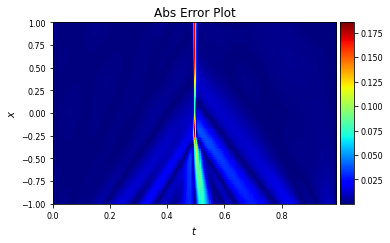

In [28]:
## ## Error ###
Error = np.abs(Exact - U_pred)
# # print(U_pred.shape)
# # print(Error.shape)
ax = plt.subplot(111)
h = plt.imshow(Error, interpolation='nearest',cmap='jet', extent=[t.min(), t.max(), x.min(), x.max()],origin='lower', aspect='auto')
# plt.colorbar(h)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.title.set_text('Abs Error Plot')
savefig('/content/drive/My Drive/ColabNotebooks/PINN/figures/abs_error')# + str(N_u) + 'N_f=' + str(N_f))

In [ ]:
# print(t[-1])
t_25_percent = int(len(t) * 0.25)
t_50_percent = int(len(t) * 0.50)
t_75_percent = int(len(t) * 0.75)
# print(t_25_percent)
# time = float(t[-1])
# time = np.around(time, decimals=3)
# print(time)

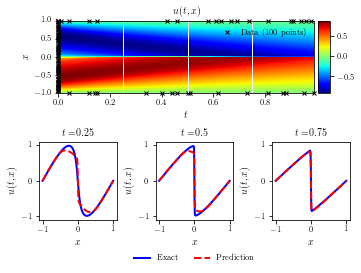

In [ ]:
# # ######################################################################
# # ############################# Plotting ###############################
# # ######################################################################
fig, ax = newfig(1.0, 1.1)
ax.axis('off')

################## Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06, bottom=1 - 1 / 3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='jet',extent=[t.min(), t.max(), x.min(), x.max()],origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label='Data (%d points)' % (u_train.shape[0]), markersize=4, clip_on=False)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[t_25_percent] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[t_50_percent] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[t_75_percent] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc='best')
ax.set_title('$u(t,x)$', fontsize=10)

# ####### Row 1: u(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1 - 1 / 3, bottom=0, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[t_25_percent, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[t_25_percent, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
time = float(t[t_25_percent])
time = np.around(time, decimals=3)
ax.set_title('$t = $' + str(time), fontsize=10)
ax.axis('square')
# ax.set_xlim([x.min(), x.max()])
# ax.set_ylim([U_pred[t_25_percent, :].min(), U_pred[t_25_percent,:.max()])
# ax.set_xlim([-3.5, 3.5])
# ax.set_ylim([-1, 2.0])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x, Exact[t_50_percent, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[t_50_percent, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
time = float(t[t_50_percent])
time = np.around(time, decimals=3)
ax.set_title('$t = $' + str(time), fontsize=10)
ax.axis('square')
# ax.set_xlim([x.min(), x.max()])
# ax.set_ylim([U_pred[t_50_percent, :].min(), U_pred[t_50_percent, :].max()])
# ax.set_xlim([-3.5, 3.5])
# ax.set_ylim([-1, 2.0])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x, Exact[t_75_percent, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[t_75_percent, :], 'r--', linewidth=2, label='Prediction')
# ax.plot(x, Exact[-2, :], 'b-', linewidth=2, label='Exact')
# ax.plot(x, U_pred[-2, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
# time = float(t[-2])
time = float(t[t_75_percent])
time = np.around(time, decimals=3)
ax.set_title('$t = $'+ str(time), fontsize=10)
ax.axis('square')
# ax.set_xlim([-3.5, 3.5])
# ax.set_ylim([-1, 2.0])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
savefig('figures/Burgers_shock_new_arch=_new_loss' + str(N_u) + 'N_f=' + str(N_f))

### Numerical Solution
<img src="figures/numerical_exact_solution.png">